<h1 align = 'center'> NIH_XRAY_GROUP2_PROJECT </h1>

# LOAD LIBRARIES

In [0]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 
                        '.*', 
                        UserWarning,
                        'warnings_filtering',
                        )

In [2]:
from tensorflow.python.client import device_lib

In [3]:
#include libraries
import os
import cv2
import sys

import numpy as np
from numpy import savez_compressed
from numpy import load
from numpy import ones
from numpy import asarray

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras import optimizers
from keras.utils import plot_model
from keras.layers import Conv2D,MaxPool2D,Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers import Reshape,LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras import backend
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model

Using TensorFlow backend.


# DATA DOWNLOADING

**SYNC TO GDRIVE FOLDER**

In [4]:
# load the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**IMPORT DATA FROM KAGGLE**

To grab your token from Kaggle, Go to your Kaggle account page (the drop-down menu in the top right corner of the screen will take you there). Then scroll down to API and hit “Create New API Token.” It will download kaggle.json file. Open it in notepad and copy the username and key in the below window.

In [0]:
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!ls

gdrive	kaggle.json  sample_data


In [0]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
!cp /content/kaggle.json /root/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets list -s nih-chest

ref                                    title                                      size  lastUpdated          downloadCount  
-------------------------------------  ----------------------------------------  -----  -------------------  -------------  
nih-chest-xrays/data                   NIH Chest X-rays                           42GB  2018-02-21 20:52:23          27614  
nih-chest-xrays/sample                 Random Sample of NIH Chest X-ray Dataset    4GB  2017-11-23 02:58:24           6126  
jbeltranleon/nih-chest-xrays-224-gray  NIH Chest X-rays 224 Gray                   2GB  2019-10-19 21:52:09              0  
jbeltranleon/nih-chest-xrays-224-rgb   NIH Chest X-rays 224 Rgb                    4GB  2019-10-21 00:36:51              0  
jessevent/all-kaggle-datasets          Complete Kaggle Datasets Collection       390KB  2018-01-16 12:32:58           1245  


Download the sample dataset

In [0]:
# download the sample datset
!kaggle datasets download -d nih-chest-xrays/sample

100% 4.19G/4.20G [00:33<00:00, 123MB/s]
100% 4.20G/4.20G [00:33<00:00, 135MB/s]


In [0]:
# unzip the dataset
!unzip  /content/{/content}/datasets/nih-chest-xrays/sample/sample.zip

Archive:  /content/{/content}/datasets/nih-chest-xrays/sample/sample.zip
  inflating: sample/images/00000013_005.png  
  inflating: sample/images/00000013_026.png  
  inflating: sample/images/00000017_001.png  
  inflating: sample/images/00000030_001.png  
  inflating: sample/images/00000032_001.png  
  inflating: sample/images/00000040_003.png  
  inflating: sample/images/00000042_002.png  
  inflating: sample/images/00000057_001.png  
  inflating: sample/images/00000061_002.png  
  inflating: sample/images/00000061_019.png  
  inflating: sample/images/00000061_025.png  
  inflating: sample/images/00000079_000.png  
  inflating: sample/images/00000080_005.png  
  inflating: sample/images/00000083_000.png  
  inflating: sample/images/00000084_000.png  
  inflating: sample/images/00000096_006.png  
  inflating: sample/images/00000099_003.png  
  inflating: sample/images/00000099_006.png  
  inflating: sample/images/00000103_001.png  
  inflating: sample/images/00000116_013.png  
  infla

# DATA LOADING

In [5]:
# import sample_labels file
labels_data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/sample_dataset_NIHxray/sample_labels.csv")
print(labels_data.shape)

(5606, 11)


In [0]:
# include only the images with one pathology condition
labels = []
for i in range(len(labels_data['Finding Labels'])):
  if labels_data['Finding Labels'][i].find('|') == -1:
    #print(labels_data['Finding Labels'][i])
    labels.append(labels_data.iloc[i,])

In [0]:
# convert to dataframe
labels_data_1 = pd.DataFrame(labels)

In [8]:
# number of different diseases
labels_data_1['Finding Labels'].value_counts()

No Finding            3044
Infiltration           503
Effusion               203
Atelectasis            192
Nodule                 144
Pneumothorax           114
Mass                    99
Consolidation           72
Pleural_Thickening      65
Cardiomegaly            50
Emphysema               42
Edema                   41
Fibrosis                38
Pneumonia               14
Hernia                   5
Name: Finding Labels, dtype: int64

In [9]:
# show labels data
labels_data_1.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143


In [10]:
labels_data_1.describe()

,Follow-up #,Patient ID,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
count,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000
mean,7.539127,14114.724600,2640.162776,2494.150886,0.155579,0.155579
std,14.589381,8401.055729,346.261747,401.423261,0.016126,0.016126
min,0.000000,17.000000,1362.000000,966.000000,0.115000,0.115000
25%,0.000000,7034.000000,2500.000000,2048.000000,0.143000,0.143000
50%,2.000000,13685.500000,2534.000000,2544.000000,0.143000,0.143000
75%,8.000000,20438.000000,2992.000000,2991.000000,0.168000,0.168000
max,177.000000,30797.000000,3266.000000,3056.000000,0.198800,0.198800


In [11]:
# define the path of images
images_data = glob("/content/gdrive/My Drive/Colab Notebooks/sample_dataset_NIHxray/sample/images/**")

print("Number of image files:",len(images_data))
images_data[0]

Number of image files: 5606


'/content/gdrive/My Drive/Colab Notebooks/sample_dataset_NIHxray/sample/images/00022914_003.png'

(1024, 1024)


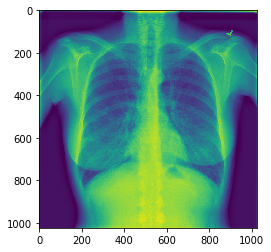

In [12]:
from PIL import Image
# show the image
im = Image.open('/content/gdrive/My Drive/Colab Notebooks/sample_dataset_NIHxray/sample/images/00022914_003.png')
print(im.size)

plt.imshow(Image.open(images_data[0]))


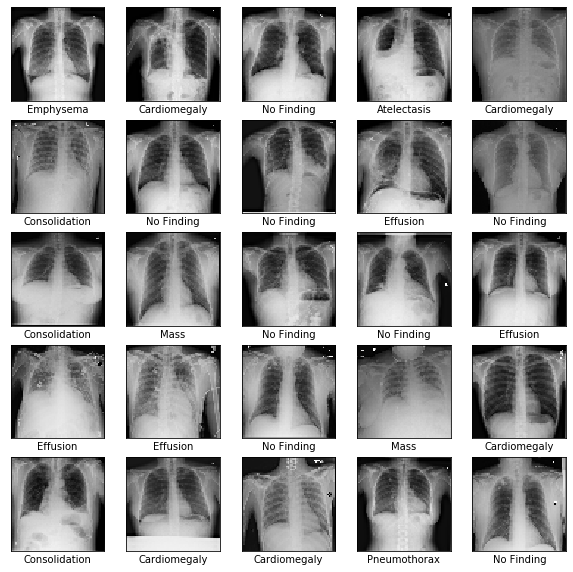

In [13]:
import cv2
import matplotlib.pyplot as plt
# Plot Multiple Images
i = 0
plt.figure(figsize = (10, 10))
#plt.subplots_adjust(wspace=0, hspace=0)
for p in images_data[:25]:
    im = cv2.imread(p)
    im = cv2.resize(im, (64, 64)) 
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([]) 
    plt.grid(False)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); 
    plt.xlabel(labels_data['Finding Labels'][i].split('|')[0])
    i += 1

# DATA CLEANING

In [0]:
#select the features
labels_data_1 = labels_data_1[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

#create new columns for each disease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

#create features, for each pathology in the list
for pathology in pathology_list :
    labels_data_1[pathology] = labels_data_1['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

In [15]:
labels_data_1.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
2,00000017_001.png,No Finding,1,17,077Y,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,00000042_002.png,No Finding,2,42,071Y,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,00000057_001.png,No Finding,1,57,071Y,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,00000061_002.png,Effusion,2,61,077Y,M,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [16]:
#remove "Y" in age field
labels_data_1['Patient Age']=labels_data_1['Patient Age'].apply(lambda x: x[:-1]).astype(int)

print(labels_data_1['Patient Age'].sort_values(ascending = False))

4242    411
3745     94
1807     89
3573     89
5403     88
       ... 
3044      3
2499      2
5203      2
1144      2
4749      1
Name: Patient Age, Length: 4626, dtype: int64


There is one patient with age 411, which should have been 41Y.Correcting the error.

In [0]:
# replace 411 with 41
labels_data_1.loc[labels_data_1['Patient Age']== 411,'Patient Age'] = 41

In [18]:
# checking for duplicate records
labels_data_1['Patient ID'].value_counts(sort = True,ascending=False)

8008     8
13670    8
27213    7
15530    7
15606    6
        ..
13420    1
21321    1
7273     1
15449    1
26625    1
Name: Patient ID, Length: 3736, dtype: int64

In [19]:
# filter patient ID 8008
labels_data_1[labels_data['Patient ID'] == 8008]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
1533,00008008_017.png,No Finding,17,8008,21,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1534,00008008_025.png,No Finding,25,8008,24,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1535,00008008_030.png,No Finding,30,8008,24,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1536,00008008_031.png,No Finding,31,8008,24,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1537,00008008_053.png,No Finding,53,8008,23,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1538,00008008_054.png,No Finding,54,8008,23,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1539,00008008_059.png,Nodule,59,8008,24,F,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1541,00008008_068.png,Infiltration,68,8008,26,F,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Te record which seems to duplicate are the records of one person at different ages, hence they are not redundant.

In [20]:
# number of unique diseases
len(labels_data_1['Finding Labels'].unique())

15

In [0]:
# add a column Condition
labels_data_1['Condition'] = np.where(labels_data_1['Finding Labels']== 'No Finding',"Normal","Disease")

In [22]:
# add a column path of image
all_image_paths = {os.path.basename(x): x for x in images_data}     # a dict of image and image path
print('Scans found:', len(all_image_paths), ', Total Headers', labels_data_1.shape[0])

labels_data_1['Path'] = labels_data_1['Image Index'].map(all_image_paths.get)

Scans found: 5606 , Total Headers 4626


In [23]:
print("Number of unique cases of pathologies:", len(labels_data['Finding Labels'].unique()))
print(pd.DataFrame(labels_data['Finding Labels'].value_counts()))

Number of unique cases of pathologies: 244
                                                    Finding Labels
No Finding                                                    3044
Infiltration                                                   503
Effusion                                                       203
Atelectasis                                                    192
Nodule                                                         144
...                                                            ...
Atelectasis|Consolidation|Edema|Infiltration|Pn...               1
Mass|Nodule|Pneumonia                                            1
Atelectasis|Consolidation|Pneumothorax                           1
Edema|Effusion|Nodule                                            1
Atelectasis|Consolidation|Mass|Pneumothorax                      1

[244 rows x 1 columns]


In [0]:
# create vector of labels
#labels_data_1['Label_Vector'] = labels_data_1.apply(lambda target: [target[pathology_list].values], 1).map(lambda target: target[0])

In [0]:
# remove the space in NO Finding value 
labels_data_1['Finding Labels'] = labels_data_1['Finding Labels'].apply(lambda x: 'NoFinding' if x == 'No Finding' else x)


In [25]:
# check for any NAs
labels_data_1.isnull().sum()

Image Index           0
Finding Labels        0
Follow-up #           0
Patient ID            0
Patient Age           0
Patient Gender        0
Cardiomegaly          0
Emphysema             0
Effusion              0
Hernia                0
Nodule                0
Pneumothorax          0
Atelectasis           0
Pleural_Thickening    0
Mass                  0
Edema                 0
Consolidation         0
Infiltration          0
Fibrosis              0
Pneumonia             0
Condition             0
Path                  0
dtype: int64

# EXPLORATORY DATA ANALYSIS

In [26]:
# store the data in temporary var for EDA
tmp_labels_df = labels_data_1

# create a pathology count
pathology_dict = []
for col_name in pathology_list:        
  y = col_name, tmp_labels_df[col_name].sum()
  pathology_dict.append(y)
# conver to dataframe
pathology_df = pd.DataFrame(pathology_dict,columns = ("Pathology","Count")).sort_values(by = ['Count'],ascending = False)
pathology_df

,Pathology,Count
11,Infiltration,503
2,Effusion,203
6,Atelectasis,192
4,Nodule,144
5,Pneumothorax,114
8,Mass,99
10,Consolidation,72
7,Pleural_Thickening,65
0,Cardiomegaly,50
1,Emphysema,42


Text(0.5, 1.0, 'Number of Pathology conditions')

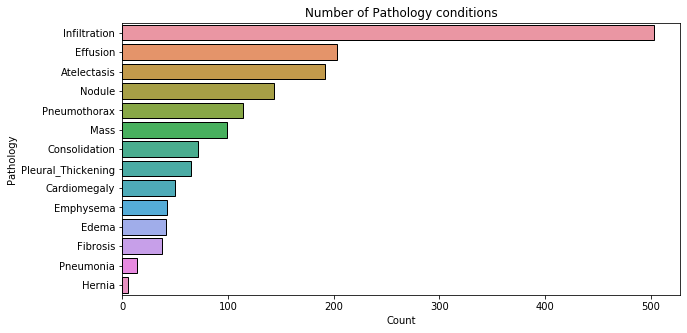

In [27]:
#plot  the graph
plt.figure(figsize = (10,5))
p = sns.barplot('Count','Pathology',data = pathology_df, edgecolor='black')
sns.color_palette("Paired")
plt.title("Number of Pathology conditions")

In [28]:
# group by patients with and without diseases w.r.t gender
tmp_labels_df.groupby(['Patient Gender','Condition'],as_index = False).agg({'Finding Labels':"count"})

,Patient Gender,Condition,Finding Labels
0,F,Disease,704
1,F,Normal,1343
2,M,Disease,878
3,M,Normal,1701


<Figure size 720x360 with 0 Axes>

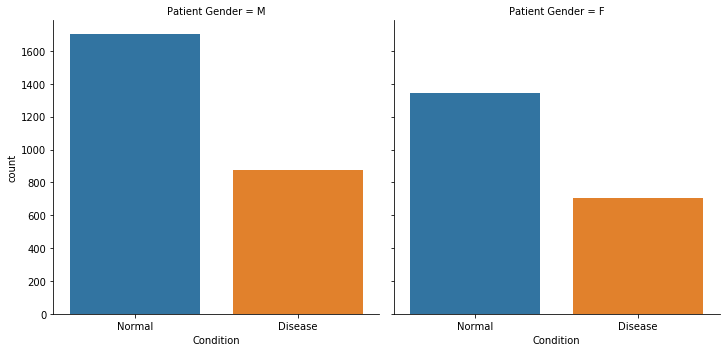

In [29]:
# distribution of patient condition w.r.t Gender
plt.figure(figsize = (10,5))
sns.catplot(x ='Condition',kind = 'count',col = "Patient Gender",data = tmp_labels_df)

Text(0.5, 1.0, 'Patient Condition w.r.t Age')

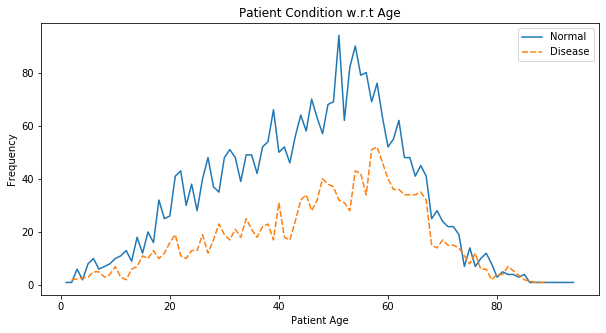

In [30]:
tmp = tmp_labels_df.groupby(['Patient Age','Condition'],as_index = False).agg({'Finding Labels':"count"})

# plot the patient condition w.r.t age
plt.figure(figsize = (10,5))
p = sns.lineplot('Patient Age','Finding Labels',hue = 'Condition',style = 'Condition',data = tmp)
p.set(ylabel = 'Frequency')
plt.legend(['Normal','Disease'])
plt.title("Patient Condition w.r.t Age")


<Figure size 432x288 with 0 Axes>

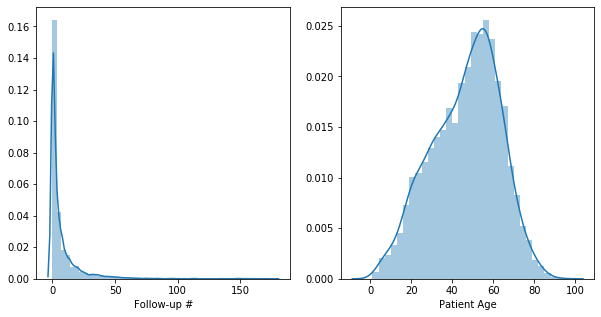

In [31]:
plt.figure(1)
plt.figure(figsize = (10,5))
plt.subplot(121)
sns.distplot(tmp_labels_df['Follow-up #'])

plt.subplot(122)
sns.distplot(tmp_labels_df['Patient Age'])



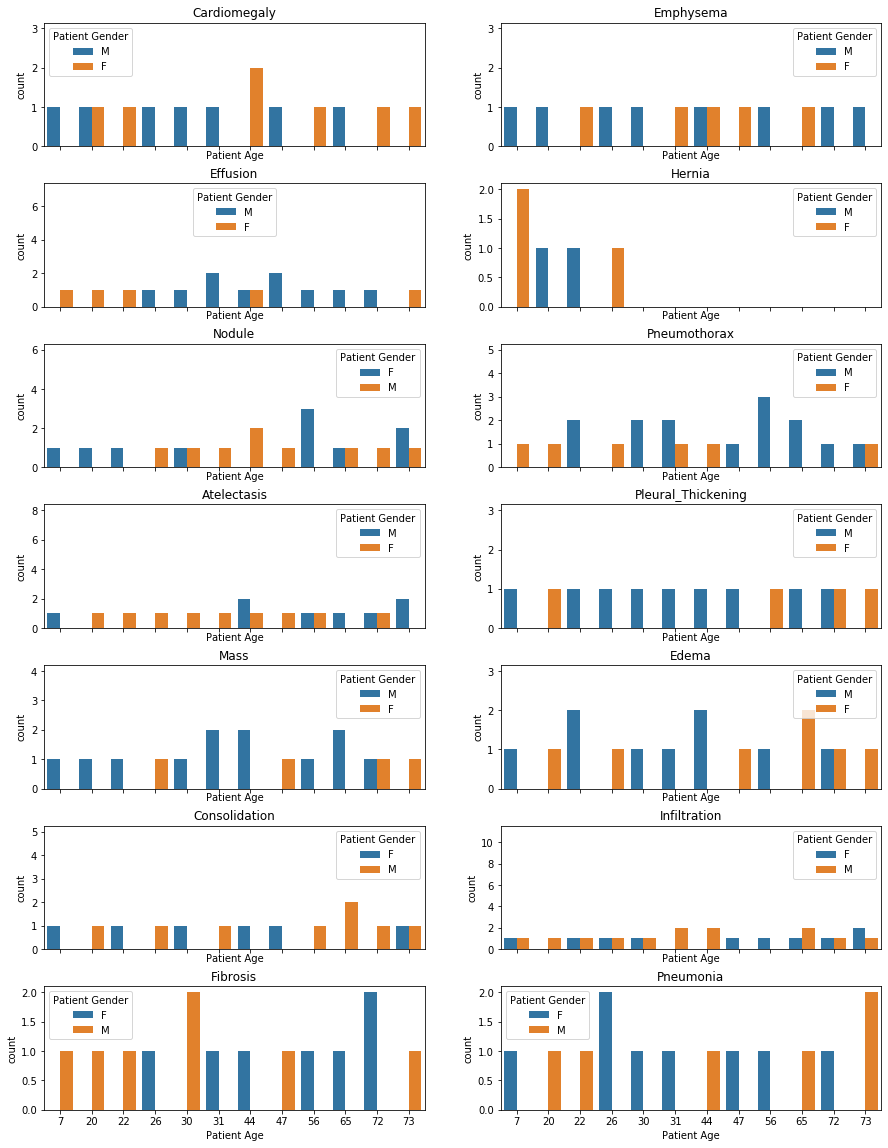

In [32]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
# plot for each pathology condition seperately
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    p=sns.countplot(x='Patient Age', hue="Patient Gender",data=tmp_labels_df[tmp_labels_df['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    #p.set_xlim(0,90)
    #p.set_xticks(x)
    #g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

# IMAGE PROCESSSING

In [33]:
# load the data
labels_data = labels_data_1
# reset the index values
labels_data.reset_index(inplace=True)
# copy the LAbels
label = labels_data['Finding Labels']

i = 0
j = 0
data_x = []
labels = []
# convert all the images into array and store in a varaible
for pt in range(len(labels_data['Path'])):
  print(pt)
  image = cv2.imread(labels_data.iloc[pt]['Path'])
  if i%1000 == 0:
    print('image {}'. format(i+1))
  if(type(image) == np.ndarray):
    image = cv2.resize(image, (128, 128))
    data_x.append(image)
    labels.append(labels_data.iloc[pt]['Finding Labels'])
    #j+=1
  else:
    print(type(image))
  i+=1
# image and label array
data_x = np.array(data_x, dtype="float64")/255.0
labels = np.array(labels)

0
image 1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

In [0]:
# save both arrays to one file in compressed format
savez_compressed('/content/gdrive/My Drive/Colab Notebooks/xray1_data.npz', data_x,labels)

In [0]:
# load dataset
data = load('/content/gdrive/My Drive/Colab Notebooks/xray1_data.npz')
data_x, labels = data['arr_0'], data['arr_1']
# convert the dataframe
labels = pd.DataFrame(labels)

# MODEL BUILDING

In [0]:
# define the X, y varaibles
y = LabelEncoder().fit_transform(labels)
x = data_x

In [37]:
# split the dataset 80-20
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.20, random_state = 123)

# quick check to see that the training and test set were split properly
print('training set - # of observations: ', x_train.shape,y_train.shape)
print('test set - # of observations): ',  x_test.shape,y_test.shape)


training set - # of observations:  (3700, 128, 128, 3) (3700,)
test set - # of observations):  (926, 128, 128, 3) (926,)


In [0]:
# convert to categorical
Y_test = y_test
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [0]:
# plot learning curve
import matplotlib.pyplot as plt
plt.style.use('ggplot') 
# function to plot accuracy and loss 

def plot_history(history):    
  acc = history.history['acc'] 
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1) 
 
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend() 
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss') 
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show() 

In [0]:
# function for classification report
def model_classification_report(x_test,y_test,model):
  y_pred = model.predict(x_test, batch_size=64, verbose=1)
  y_pred_labels = (y_pred > 0.5).astype(np.int)
  print(classification_report(y_test, y_pred_labels))


## DNN MODEL

In [41]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                495       
Total params: 6,296,207
Trainable params: 6,296,207
Non-trainable params: 0
_________________________________________________________________
None


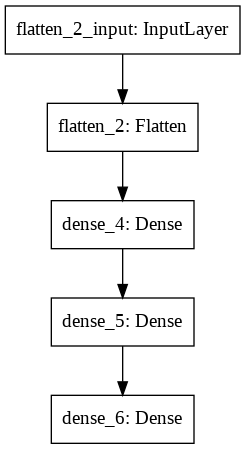

In [43]:
# create model
model = Sequential()
model.add(Flatten(input_shape=(128,128, 3)))
model.add(Dense(128, input_shape=(128,128, 3), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(15, activation='sigmoid'))

# Compile model
#sgd = optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, neserov=False)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='dnn_model.png')


In [44]:
# Fit the model
dnn_simple = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=25, batch_size=100,verbose=1)

# Final evaluation of the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=False) 
print("Training Accuracy: {:.4f}".format(accuracy)) 
loss, accuracy = model.evaluate(x_test, y_test, verbose=False) 
print("Testing Accuracy:  {:.4f}".format(accuracy))




Train on 3700 samples, validate on 926 samples
Epoch 1/25





3700/3700 [==============================] - 7s 2ms/step - loss: 1.4412 - acc: 0.8593 - val_loss: 1.3336 - val_acc: 0.8849
Epoch 2/25
3700/3700 [==============================] - 2s 461us/step - loss: 1.3640 - acc: 0.8902 - val_loss: 1.3635 - val_acc: 0.8914
Epoch 3/25
3700/3700 [==============================] - 2s 460us/step - loss: 1.3641 - acc: 0.8915 - val_loss: 1.3868 - val_acc: 0.8916
Epoch 4/25
3700/3700 [==============================] - 2s 460us/step - loss: 1.3893 - acc: 0.8890 - val_loss: 1.3984 - val_acc: 0.8918
Epoch 5/25
3700/3700 [==============================] - 2s 460us/step - loss: 1.3813 - acc: 0.8923 - val_loss: 1.3967 - val_acc: 0.8916
Epoch 6/25
3700/3700 [==============================] - 2s 462us/step - loss: 1.3961 - acc: 0.8904 - val_loss: 1.3973 - val_acc: 0.8807
Epoch 7/25
3700/3700 [==============================] - 2s 458us/step - loss: 1.4015 - acc: 0.8886 - val_loss: 1.3993 - val_acc: 0.

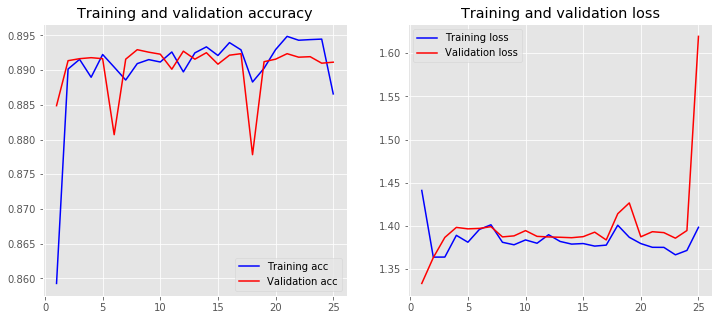

In [45]:
# call plot function
plot_history(dnn_simple)

In [46]:
# call classification report
model_classification_report(x_test,y_test,model)

926/926 [==============================] - 0s 308us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.06      1.00      0.10        51
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00       106
           9       0.00      0.00      0.00        25
          10       0.63      1.00      0.77       582
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        23

   micro avg       0.34      0.68      0.46       926
   macro avg       0.05

## CNN MODEL



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
___

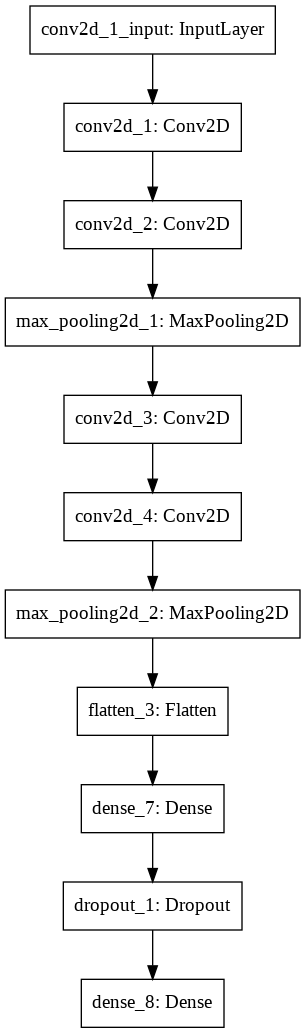

In [47]:
# define the input and output
input_shape = (128,128,3)
num_classes = 15

# Model design # Initialising the CNN
model = Sequential()
# Convolution
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# Convolution
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
#Pooling
model.add(MaxPool2D(pool_size = (2, 2)))

# Convolution
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# Convolution
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
#Pooling
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())
# Full connection
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(num_classes, activation='sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'adam' , loss = "binary_crossentropy", metrics=["accuracy"])

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='cnn_model.png')


In [57]:
batch_size = 100
epochs = 12

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test,verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# model.save("/content/gdrive/My Drive/Colab Notebooks/model.h5")
# print("Saved model to disk")

Train on 3700 samples, validate on 926 samples
Epoch 1/12
3700/3700 [==============================] - 9s 2ms/step - loss: 0.0045 - acc: 0.9987 - val_loss: 0.5328 - val_acc: 0.9425
Epoch 2/12
3700/3700 [==============================] - 9s 2ms/step - loss: 0.0050 - acc: 0.9985 - val_loss: 0.5179 - val_acc: 0.9408
Epoch 3/12
3700/3700 [==============================] - 9s 2ms/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.5159 - val_acc: 0.9385
Epoch 4/12
3700/3700 [==============================] - 9s 2ms/step - loss: 0.0023 - acc: 0.9993 - val_loss: 0.5617 - val_acc: 0.9439
Epoch 5/12
3700/3700 [==============================] - 9s 2ms/step - loss: 0.0032 - acc: 0.9992 - val_loss: 0.5470 - val_acc: 0.9391
Epoch 6/12
3700/3700 [==============================] - 9s 2ms/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.5436 - val_acc: 0.9432
Epoch 7/12
3700/3700 [==============================] - 9s 2ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.5704 - val_acc: 0.9424
Epoch 8/12
3700

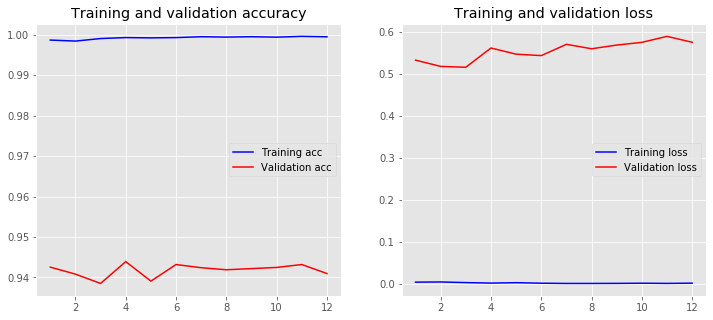

In [58]:
# call plot function
plot_history(history)

In [59]:
# call classification report
model_classification_report(x_test,y_test,model)

926/926 [==============================] - 1s 860us/step
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        42
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.15      0.05      0.07       106
           9       0.00      0.00      0.00        25
          10       0.63      0.71      0.67       582
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        23

   micro avg       0.57      0.46      0.51       926
   macro avg       0.07

In [60]:
# predict the classes
predicted_classes = model.predict_classes(x_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == Y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != Y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# # adapt figure size to accomodate 18 subplots
# plt.rcParams['figure.figsize'] = (7,14)

# figure_evaluation = plt.figure()

# # plot 9 correct predictions
# for i, correct in enumerate(correct_indices[:9]):
#     plt.subplot(6,3,i+1)
#     plt.imshow(x_test[correct], cmap='gray', interpolation='none')
#     plt.title("Pre: {}, True: {}".format(predicted_classes[correct],Y_test[correct]))
#     plt.xticks([])
#     plt.yticks([])

# # plot 9 incorrect predictions
# for i, incorrect in enumerate(incorrect_indices[:9]):
#     plt.subplot(6,3,i+10)
#     plt.imshow(x_test[incorrect], cmap='gray', interpolation='none')
#     plt.title(
#       "Pred {}, True: {}".format(predicted_classes[incorrect], 
#                                        Y_test[incorrect]))
#     plt.xticks([])
#     plt.yticks([])

# figure_evaluation


484  classified correctly
442  classified incorrectly


## CNN_MODEL_DROPOUT

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)       

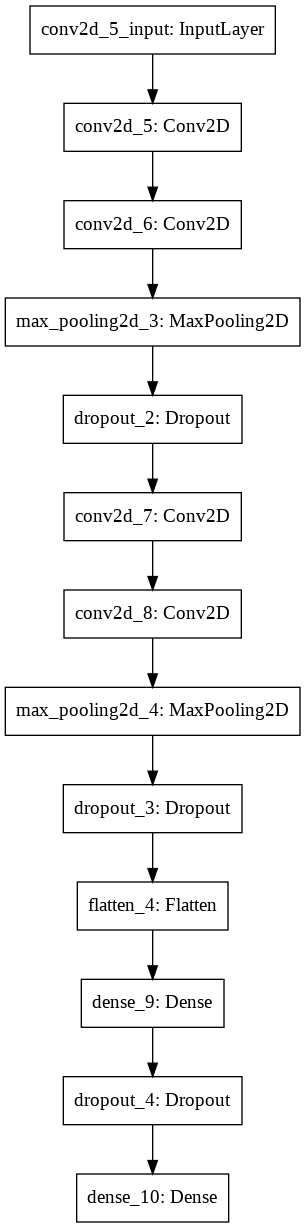

In [61]:
# define the input and output
input_shape = (128,128,3)
num_classes = 15

# Model design # Initialising the CNN
model = Sequential()
# Convolution
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# Convolution
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
#Pooling
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

# Convolution
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# Convolution
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
#Pooling
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

# Flattening
model.add(Flatten())
# Full connection
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(num_classes, activation='sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'adam' , loss = "binary_crossentropy", metrics=["accuracy"])

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='cnn_model_droupout.png')


In [62]:
batch_size = 100
epochs = 10

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test,verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# model.save("model.h5")
#print("Saved model to disk")

Train on 3700 samples, validate on 926 samples
Epoch 1/10
3700/3700 [==============================] - 10s 3ms/step - loss: 0.1651 - acc: 0.9394 - val_loss: 0.1596 - val_acc: 0.9505
Epoch 2/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1406 - acc: 0.9545 - val_loss: 0.1537 - val_acc: 0.9505
Epoch 3/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1394 - acc: 0.9553 - val_loss: 0.1563 - val_acc: 0.9507
Epoch 4/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1350 - acc: 0.9557 - val_loss: 0.1522 - val_acc: 0.9506
Epoch 5/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1295 - acc: 0.9568 - val_loss: 0.1563 - val_acc: 0.9500
Epoch 6/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1219 - acc: 0.9581 - val_loss: 0.1597 - val_acc: 0.9500
Epoch 7/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1124 - acc: 0.9601 - val_loss: 0.1788 - val_acc: 0.9473
Epoch 8/10
370

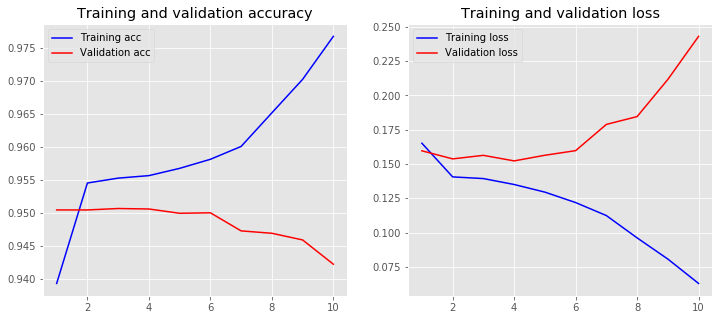

In [63]:
# call plot function
plot_history(history)

In [64]:
# call classification report
model_classification_report(x_test,y_test,model)

926/926 [==============================] - 1s 999us/step
              precision    recall  f1-score   support

           0       0.13      0.07      0.09        42
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.25      0.02      0.04        51
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.23      0.11      0.15       106
           9       0.00      0.00      0.00        25
          10       0.64      0.78      0.70       582
          11       0.00      0.00      0.00        36
          12       0.17      0.09      0.12        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        23

   micro avg       0.58      0.51      0.54       926
   macro avg       0.09

In [65]:
# predict the classes
predicted_classes = model.predict_classes(x_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == Y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != Y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")



524  classified correctly
402  classified incorrectly


## CNN_MODEL_BATCHNORMALIZATION

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)       

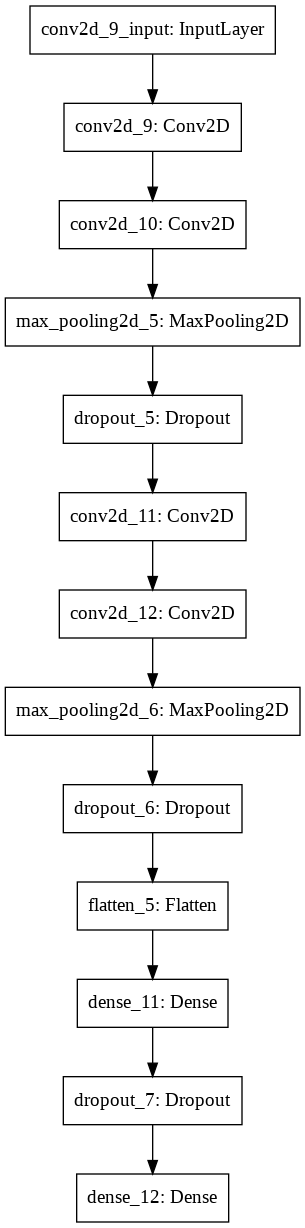

In [66]:
# define the input and output
input_shape = (128,128,3)
num_classes = 15

# Model design # Initialising the CNN
model = Sequential()
# Convolution
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# Convolution
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
#Pooling
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

BatchNormalization(axis=-1)
# Convolution
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# Convolution
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
#Pooling
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

BatchNormalization()
# Flattening
model.add(Flatten())
# Full connection
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(num_classes, activation='sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'adam' , loss = "binary_crossentropy", metrics=["accuracy"])

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='cnn_model_batchnormal.png')


In [67]:
batch_size = 100
epochs = 10

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test,verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#model.save("model.h5")
#print("Saved model to disk")

Train on 3700 samples, validate on 926 samples
Epoch 1/10
3700/3700 [==============================] - 10s 3ms/step - loss: 0.1697 - acc: 0.9396 - val_loss: 0.1729 - val_acc: 0.9505
Epoch 2/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1419 - acc: 0.9541 - val_loss: 0.1554 - val_acc: 0.9505
Epoch 3/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1392 - acc: 0.9548 - val_loss: 0.1561 - val_acc: 0.9506
Epoch 4/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1376 - acc: 0.9554 - val_loss: 0.1529 - val_acc: 0.9508
Epoch 5/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1346 - acc: 0.9556 - val_loss: 0.1483 - val_acc: 0.9504
Epoch 6/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1304 - acc: 0.9563 - val_loss: 0.1523 - val_acc: 0.9505
Epoch 7/10
3700/3700 [==============================] - 9s 2ms/step - loss: 0.1234 - acc: 0.9577 - val_loss: 0.1593 - val_acc: 0.9476
Epoch 8/10
370

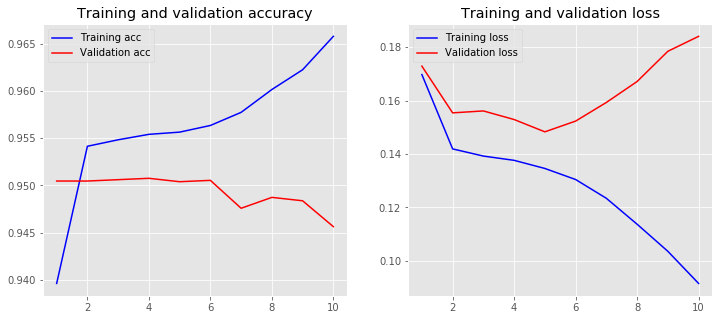

In [68]:
# call plot function
plot_history(history)

In [69]:
# call classification report
model_classification_report(x_test,y_test,model)

926/926 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.20      0.02      0.04        51
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.25      0.06      0.09       106
           9       0.00      0.00      0.00        25
          10       0.64      0.81      0.72       582
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        23

   micro avg       0.61      0.52      0.56       926
   macro avg       0.07  

In [70]:
# predict the classes
predicted_classes = model.predict_classes(x_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == Y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != Y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")




540  classified correctly
386  classified incorrectly


In [71]:
model.save("/content/gdrive/My Drive/Colab Notebooks/model.h5")
print("Saved model to disk")

Saved model to disk


## CNN MODEL with DATA AUGMENTATION

In [0]:
# define Image generator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 126, 126, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 63, 63, 128)      

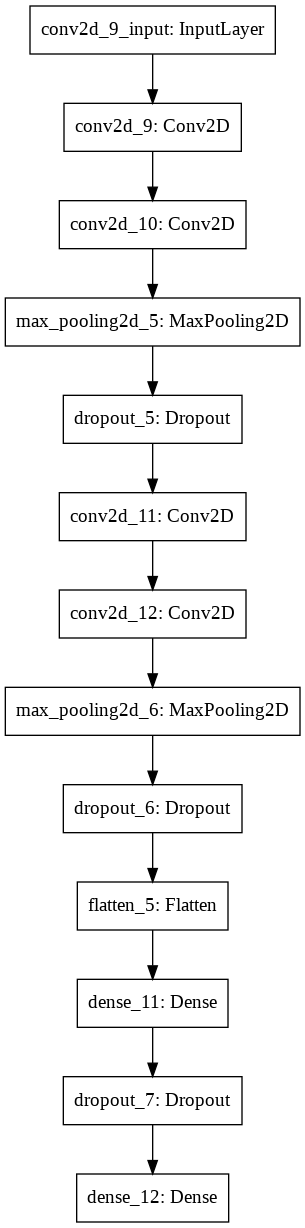

In [73]:
# define the cnn model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(128,128,3)))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(128, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(128, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

#connected layer
model_cnn.add(Flatten())
model_cnn.add(Dense(128))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(15, activation='sigmoid'))
model_cnn.compile(optimizer = 'Adam',loss="binary_crossentropy",metrics=["accuracy"])

# summarize layers
print(model_cnn.summary())

# plot graph
plot_model(model, to_file='cnn_model_Imagegenerator.png')

In [74]:
# fit the model
cnn_model_fit = model_cnn.fit_generator(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test), steps_per_epoch=len(x_train)//32, epochs = 25, verbose=1)

Epoch 1/25
115/115 [==============================] - 22s 191ms/step - loss: 0.1861 - acc: 0.9424 - val_loss: 0.1483 - val_acc: 0.9505
Epoch 2/25
115/115 [==============================] - 18s 157ms/step - loss: 0.1558 - acc: 0.9534 - val_loss: 0.1471 - val_acc: 0.9505
Epoch 3/25
115/115 [==============================] - 18s 157ms/step - loss: 0.1506 - acc: 0.9533 - val_loss: 0.1511 - val_acc: 0.9505
Epoch 4/25
115/115 [==============================] - 18s 158ms/step - loss: 0.1474 - acc: 0.9545 - val_loss: 0.1469 - val_acc: 0.9505
Epoch 5/25
115/115 [==============================] - 18s 158ms/step - loss: 0.1451 - acc: 0.9547 - val_loss: 0.1481 - val_acc: 0.9505
Epoch 6/25
115/115 [==============================] - 18s 157ms/step - loss: 0.1453 - acc: 0.9546 - val_loss: 0.1471 - val_acc: 0.9505
Epoch 7/25
115/115 [==============================] - 18s 157ms/step - loss: 0.1449 - acc: 0.9552 - val_loss: 0.1468 - val_acc: 0.9505
Epoch 8/25
115/115 [==============================] - 1

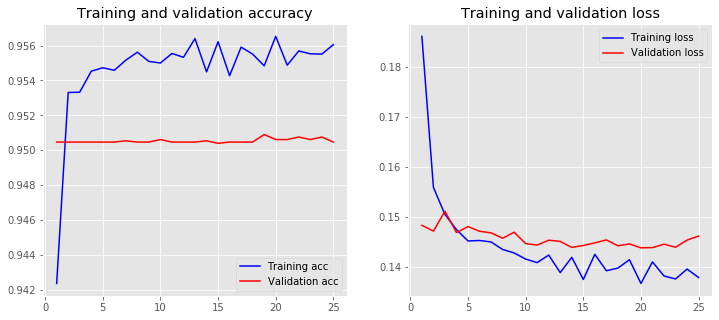

In [75]:
# call plot function
plot_history(cnn_model_fit)

In [76]:
# call classification report
model_classification_report(x_test,y_test,model_cnn)

926/926 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00       106
           9       0.00      0.00      0.00        25
          10       0.63      0.98      0.77       582
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        23

   micro avg       0.63      0.62      0.62       926
   macro avg       0.04  

## LSTM

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)       

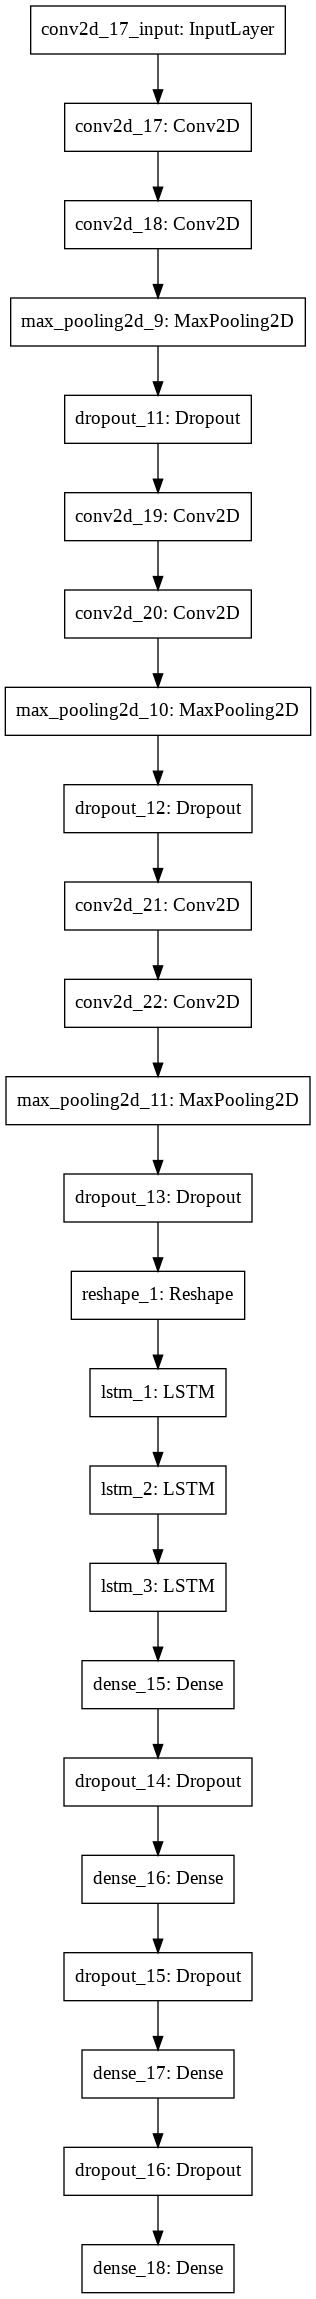

In [77]:
# define LSTM
input_shape=(128,128,3)
num_classes=15

lstm_model = Sequential()
lstm_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# Convolution
lstm_model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
#Pooling
lstm_model.add(MaxPool2D(pool_size = (2, 2)))
lstm_model.add(Dropout(0.25))

# Convolution
lstm_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))

# Convolution
lstm_model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
#Pooling
lstm_model.add(MaxPool2D(pool_size=(2, 2)))
lstm_model.add(Dropout(0.40))
lstm_model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))

# Convolution
lstm_model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
#Pooling
lstm_model.add(MaxPool2D(pool_size=(2, 2)))
lstm_model.add(Dropout(0.40))
lstm_model.add(Reshape((16,16*128)))
lstm_model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
lstm_model.add(LSTM(200,dropout=0.2, recurrent_dropout=0.2,return_sequences=True))

# fully connected layer
lstm_model.add(LSTM(150,return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(128,activation='softmax'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(256,activation='softmax'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(512,activation='softmax'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(num_classes,activation='sigmoid'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lstm_model.compile(loss = 'binary_crossentropy', optimizer=sgd,metrics = ['accuracy'])

# summarize layers
print(lstm_model.summary())

# plot graph
plot_model(lstm_model, to_file='lstm_model.png')

In [78]:
import keras
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
batch_size=1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience= 30)
callbacks=[early_stop]
history = lstm_model.fit_generator(datagen.flow(x_train,y_train),
                              epochs = 50,verbose = 1,steps_per_epoch=x_train.shape[0]//batch_size,
                              callbacks=callbacks,validation_data = (x_test,y_test))

score = lstm_model.evaluate(x_test, y_test,verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
3/3 [==============================] - 8s 3s/step - loss: 0.6924 - acc: 0.6257 - val_loss: 0.6917 - val_acc: 0.8340
Epoch 2/50
3/3 [==============================] - 3s 912ms/step - loss: 0.6910 - acc: 0.8569 - val_loss: 0.6897 - val_acc: 0.9505
Epoch 3/50
3/3 [==============================] - 3s 910ms/step - loss: 0.6888 - acc: 0.9451 - val_loss: 0.6871 - val_acc: 0.9505
Epoch 4/50
3/3 [==============================] - 3s 925ms/step - loss: 0.6860 - acc: 0.9639 - val_loss: 0.6841 - val_acc: 0.9505
Epoch 5/50
3/3 [==============================] - 3s 915ms/step - loss: 0.6830 - acc: 0.9542 - val_loss: 0.6808 - val_acc: 0.9505
Epoch 6/50
3/3 [==============================] - 3s 921ms/step - loss: 0.6797 - acc: 0.9431 - val_loss: 0.6773 - val_acc: 0.9505
Epoch 7/50
3/3 [==============================] - 3s 921ms/step - loss: 0.6761 - acc: 0.9458 - val_loss: 0.6736 - val_acc: 0.9505
Epoch 8/50
3/3 [==============================] - 3s 921ms/step - loss: 0.6720 - acc: 0.9653 

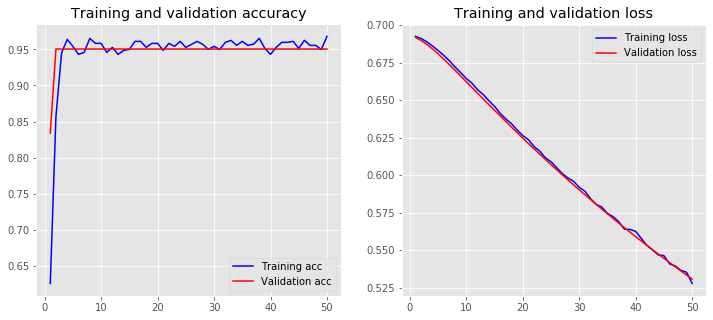

In [79]:
# call plot function
plot_history(history)

In [80]:
# call classification report
model_classification_report(x_test,y_test,lstm_model)

926/926 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00       106
           9       0.00      0.00      0.00        25
          10       0.63      1.00      0.77       582
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        23

   micro avg       0.63      0.63      0.63       926
   macro avg       0.04  

## VGG16

In [0]:
# calculate fscore score for multi-label classification
def fscore(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fscore, averaged across each class
    bb = beta ** 2
    fscore = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    
    return fscore

In [0]:
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=15):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fscore])
    return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Fscore')
    plt.plot(history.history['fscore'], color='blue', label='train')
    plt.plot(history.history['val_fscore'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

In [0]:
# run the test harness for evaluating a model
def run_vgg16_model():
    # load dataset
    trainX, trainY, testX, testY = x_train, y_train, x_test, y_test
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    loss, fscore = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fscore=%.3f' % (loss, fscore))
    # learning curves
    summarize_diagnostics(history)
    return model

In [87]:
# entry point, run the test harness
model = run_vgg16_model()

> loss=0.147, fscore=0.629


In [88]:
# call classification report
model_classification_report(x_test,y_test,model)

926/926 [==============================] - 5s 6ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00       106
           9       0.00      0.00      0.00        25
          10       0.63      1.00      0.77       582
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        23

   micro avg       0.63      0.63      0.63       926
   macro avg       0.04  

## VGG16- FINETUNNIG

In [91]:
# # vgg with fine-tuning and data augmentation for the xray dataset
def define_model(in_shape=(128, 128, 3), out_shape=15):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # allow last vgg block to be trainable
    model.get_layer('block5_conv1').trainable = True
    model.get_layer('block5_conv2').trainable = True
    model.get_layer('block5_conv3').trainable = True
    model.get_layer('block5_pool').trainable = True
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fscore])
    return  model

# run the test harness for evaluating a model
def run_vgg16_model(x_train,y_train, x_test, y_test):
    # load dataset
    trainX, trainY, testX, testY = x_train,y_train, x_test, y_test
    # create data generator
    train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    train_datagen.mean = [123.68, 116.779, 103.939]
    test_datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterators
    train_it = train_datagen.flow(trainX, trainY, batch_size=128)
    test_it = test_datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    loss, fscore = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fscore=%.3f' % (loss, fscore))
    # learning curves
    summarize_diagnostics(history)
 
# entry point, to run the model
run_vgg16_model(x_train,y_train, x_test, y_test)

> loss=2.112, fscore=0.012


In [92]:
# call classification report
model_classification_report(x_test,y_test,model)

926/926 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00       106
           9       0.00      0.00      0.00        25
          10       0.63      1.00      0.77       582
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        23

   micro avg       0.63      0.63      0.63       926
   macro avg       0.04  

# FINAL MODEL PREDICTION


540  classified correctly
386  classified incorrectly


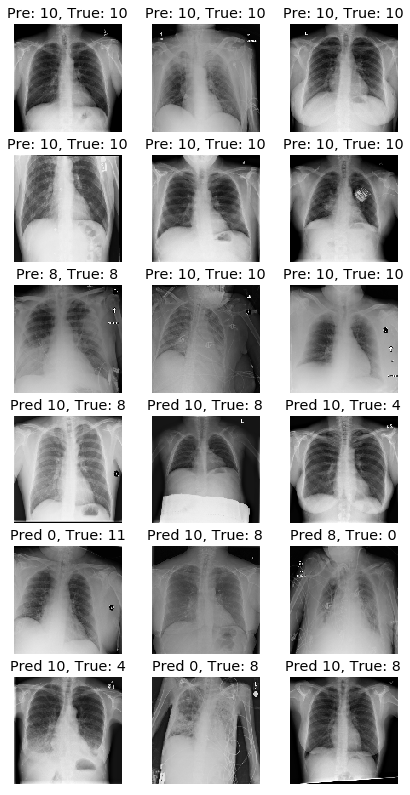

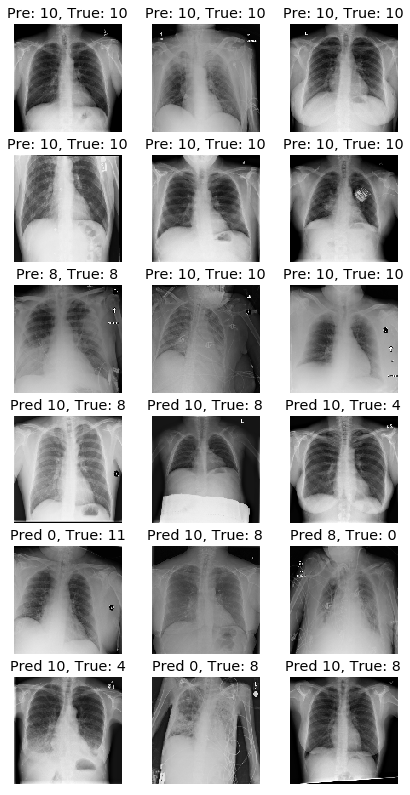

In [94]:
from keras.models import load_model
# load the final model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/model.h5')

# predict the classes
predicted_classes = model.predict_classes(x_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == Y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != Y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(x_test[correct], cmap='gray', interpolation='none')
    plt.title("Pre: {}, True: {}".format(predicted_classes[correct],Y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(x_test[incorrect], cmap='gray', interpolation='none')
    plt.title(
      "Pred {}, True: {}".format(predicted_classes[incorrect], 
                                       Y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation

# CONCLUSION

Among all the models,CNN model with dropuout and batch normalization was good on NIH Xray dataset with accuracy of 95%(Approximately).